In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed
from keras import backend as K

In [2]:
warnings.filterwarnings("ignore")

In [2]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2014-12-29',end='2021-12-31')
JPM['Rendimenti'] = JPM['Open'].diff() # aggiungo i valori dei rendimenti
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Rendimenti
count,1765.000000,1765.000000,1765.000000,1765.000000,1.765000e+03,1765.000000,1765.0,1764.000000
mean,92.150689,93.008318,91.302414,92.150635,1.513972e+07,0.010561,0.0,0.060192
std,32.584003,32.882706,32.299043,32.572711,6.646317e+06,0.087102,0.0,1.613196
min,44.681974,45.383567,41.570076,44.559059,3.324300e+06,0.000000,0.0,-10.086377
25%,57.656303,57.925783,57.416991,57.690491,1.088610e+07,0.000000,0.0,-0.622687
50%,93.184584,94.177597,92.318723,93.221794,1.354240e+07,0.000000,0.0,0.070241
75%,104.620881,105.376342,103.911238,104.580666,1.725090e+07,0.000000,0.0,0.763077
max,170.417716,170.664397,168.276520,169.500061,5.619230e+07,1.000000,0.0,10.493423


ANALISI ESPLORATIVA

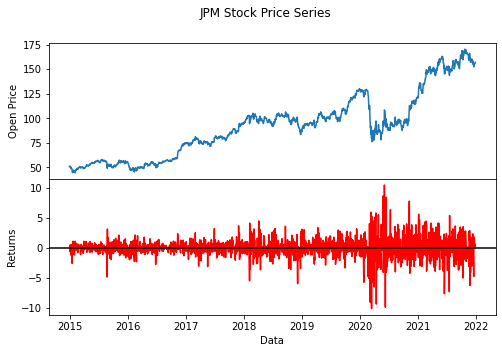

In [3]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'], color ="red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()
plt.show()
# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\serie.pdf", bbox_inches='tight', format="pdf")


c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


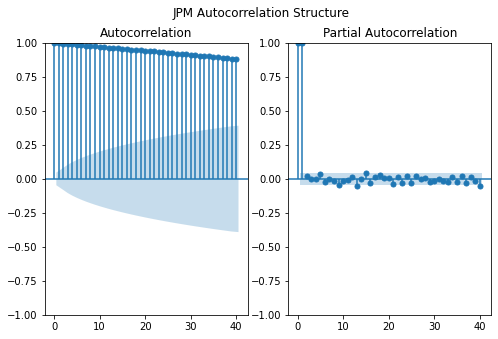

In [4]:
# ACF E PACF della serie dei prezzi
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\cor.pdf", bbox_inches='tight', format="pdf")

In [5]:
#Test ADF per la verifica dell'ipotesi nulla di radice unitaria
adfTest = adfuller(JPM['Open'], autolag = 'AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
print('Augmented Dickey-Fuller Test Results:\n')
print(dfResults)
# non si rifiuta l'ipotesi nulla di radice unitaria

Augmented Dickey-Fuller Test Results:

ADF Test Statistic       -0.431580
P-Value                   0.904691
# Lags Used               5.000000
# Observations Used    1759.000000
dtype: float64


MODELLAZIONE ARIMA



In [8]:
# creazione del train e del test set
size = int(len(JPM) * 0.72)
print(size)
dataset_train = JPM[0:size]
training_set = dataset_train.iloc[:, 0:1].values
dataset_test = JPM[size:]
test_set = dataset_test.iloc[:,0:1].values
print(training_set.shape)
print(test_set.shape)

1270
(1270, 1)
(495, 1)


In [9]:
# con finestra di 5 giorni
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(0, test_set.shape[0],5):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=5)
    yhat = output
    predictions.append(yhat)
    obs = test_set[t]
    #print(obs)
    history.append(obs)
    #print(history)

In [161]:
# con finestra di un giorno
#history = [x for x in training_set]
#predictions = list()
# walk-forward validation
#for t in range(len(test_set)):
#    model = ARIMA(history, order=(1,1,0))
#    model_fit = model.fit()
#    output = model_fit.forecast()
#    yhat = output[0]
#    predictions.append(yhat)
#    obs = test_set[t]
#    history.append(obs)

In [8]:
print(model_fit.summary()) # si rifiuta l'ipotesi nulla di normalità dei residui; il Ljung box è non significativo e quindi il modello filtra la serie
# dalla dipendenza seriale

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1536
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3034.599
Date:                Tue, 28 Jun 2022   AIC                           6073.198
Time:                        18:01:14   BIC                           6083.871
Sample:                             0   HQIC                          6077.169
                               - 1536                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0174      0.014     -1.264      0.206      -0.044       0.010
sigma2         3.0526      0.042     71.872      0.000       2.969       3.136
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [10]:
print(test_set.shape)
print(np.array(predictions).shape)
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)

(495, 1)
(99, 5)


In [11]:
# valutazione delle previsioni
mse = mean_squared_error(test_set, predictions)
print('Mean Squared Error:\t',mse)
print('Root mean Squared Error:\t', np.sqrt(mse))

Mean Squared Error:	 46.58937283261663
Root mean Squared Error:	 6.825640836772518


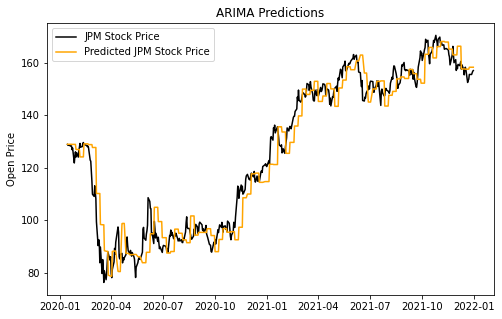

In [12]:
predictions = pd.DataFrame(predictions)
predictions= predictions.set_index(dataset_test.index)
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], color ="black", label = "JPM Stock Price")
plt.plot(predictions, color="orange", label = "Predicted JPM Stock Price")
plt.legend()
plt.ylabel("Open Price")
plt.title("ARIMA Predictions")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_arima.pdf", bbox_inches='tight', format="pdf")

In [37]:
# ARIMA(2,1,0)
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(0, test_set.shape[0],5):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(5)
    yhat = output
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [38]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1764
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3344.142
Date:                Mon, 27 Jun 2022   AIC                           6694.284
Time:                        22:33:30   BIC                           6710.708
Sample:                             0   HQIC                          6700.353
                               - 1764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0404      0.014     -2.852      0.004      -0.068      -0.013
ar.L2          0.0174      0.014      1.227      0.220      -0.010       0.045
sigma2         2.6008      0.042     61.542      0.0

CONVOLUTIONAL NEURAL NETWORK

In [13]:
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = mc.fit_transform(training_set)
print(training_set_scaled.shape)

(1270, 1)


In [14]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set_scaled.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i:i+temp])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(253, 5, 1)
(253, 5, 1)
(253, 5, 1)


In [15]:
# Costruzione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp:].values
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(99, 5, 1)


In [16]:
# rete CNN base
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
______________________________________________________

In [17]:

batch_size = 4
epochs = 20
set_seed(190)
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_5_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 1s 1ms/step - loss: 0.1079 - root_mean_squared_error: 0.3285
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2240
Epoch 3/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0472 - root_mean_squared_error: 0.2173
Epoch 4/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2161
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2162
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squar

In [18]:
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price= predicted_stock_price.set_index(dataset_test.index)

Mean Squared Error:	 1530.289278601698
Root Mean Squared Error:	 39.11891203243896


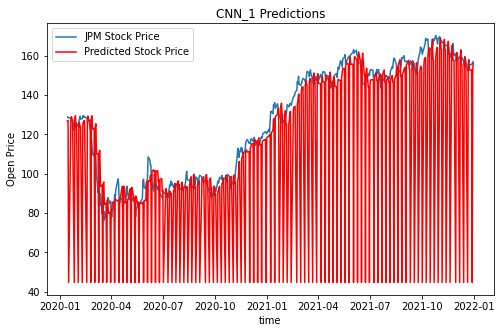

In [19]:
# MSE e rappresentazione delle previsioni
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN_1 Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1.pdf", bbox_inches='tight', format="pdf")

In [20]:
# modello con kernel_size=2
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
set_seed(190)
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_5_CNN.fit(X_train, y_train, batch_size=4, epochs=20)

Epoch 1/20
64/64 [==============================] - 1s 2ms/step - loss: 0.1131 - root_mean_squared_error: 0.3363
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0930 - root_mean_squared_error: 0.3050
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0927 - root_mean_squared_error: 0.3044
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0927 - root_mean_squared_error: 0.3044
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0927 - root_mean_squared_error: 0.3045
Epoch 6/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0927 - root_mean_squared_error: 0.3044
Epoch 7/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0927 - root_mean_squared_error: 0.3045
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0927 - root_mean_squared_error: 0.3045
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0927 - root_mean_squar

Mean Squared Error:	 3027.841096158965
Root Mean Squared Error:	 55.025822085262526


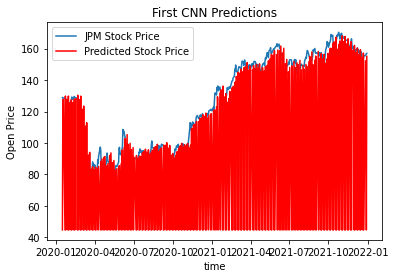

In [21]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [22]:
# MODIFICO IL LEARING RATE A 0.02
model_5_CNN_2 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
set_seed(190)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model_5_CNN_2.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model_5_CNN_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 1s 1ms/step - loss: 0.0742 - root_mean_squared_error: 0.2723
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0478 - root_mean_squared_error: 0.2187
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0473 - root_mean_squared_error: 0.2174
Epoch 4/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0479 - root_mean_squared_error: 0.2190
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0476 - root_mean_squared_error: 0.2182
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0471 - root_mean_squared_error: 0.2171
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0485 - root_mean_squared_error: 0.2203
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0021 - root_mean_squar

Mean Squared Error:	 31.336650078943293
Root Mean Squared Error:	 5.597914797399412


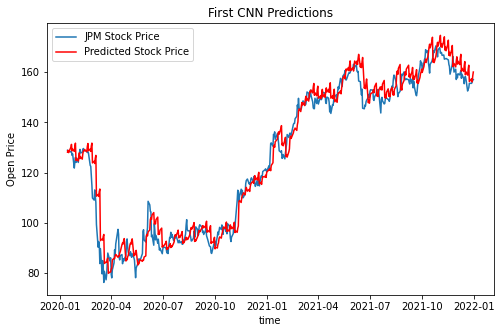

In [24]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_2.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [25]:
# AUMENTO IL BATCH_SIZE A 10
set_seed(12)
model_5_CNN_3 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_3.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_5_CNN_3.fit(X_train,y_train,epochs=20,batch_size=10)

Epoch 1/20
26/26 [==============================] - 0s 1ms/step - loss: 0.1193 - root_mean_squared_error: 0.3455
Epoch 2/20
26/26 [==============================] - 0s 1ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512
Epoch 3/20
26/26 [==============================] - 0s 2ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757
Epoch 4/20
26/26 [==============================] - 0s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477
Epoch 5/20
26/26 [==============================] - 0s 2ms/step - loss: 8.5663e-04 - root_mean_squared_error: 0.0293
Epoch 6/20
26/26 [==============================] - 0s 2ms/step - loss: 7.0703e-04 - root_mean_squared_error: 0.0266
Epoch 7/20
26/26 [==============================] - 0s 2ms/step - loss: 6.8587e-04 - root_mean_squared_error: 0.0262
Epoch 8/20
26/26 [==============================] - 0s 2ms/step - loss: 6.9681e-04 - root_mean_squared_error: 0.0264
Epoch 9/20
26/26 [==============================] - 0s 2ms/step - loss: 7.0939e-

Mean Squared Error:	 32.346229355437906
Root Mean Squared Error:	 5.687374557336444


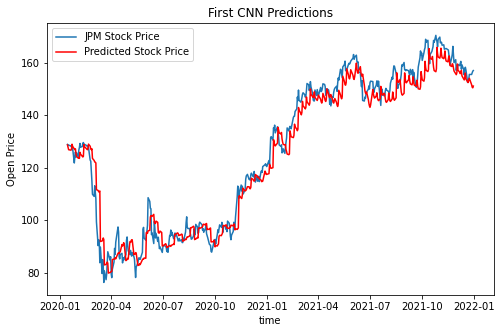

In [26]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_3.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [27]:
# AUMENTO IL NUMERO DI EPOCHE A 60
set_seed(10)
model_5_CNN_4 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_4.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_5_CNN_4.fit(X_train,y_train,epochs=60,batch_size=4)

Epoch 1/60
64/64 [==============================] - 1s 2ms/step - loss: 0.0832 - root_mean_squared_error: 0.2885
Epoch 2/60
64/64 [==============================] - 0s 2ms/step - loss: 0.0315 - root_mean_squared_error: 0.1776
Epoch 3/60
64/64 [==============================] - 0s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497
Epoch 4/60
64/64 [==============================] - 0s 2ms/step - loss: 9.6494e-04 - root_mean_squared_error: 0.0311
Epoch 5/60
64/64 [==============================] - 0s 2ms/step - loss: 7.6275e-04 - root_mean_squared_error: 0.0276
Epoch 6/60
64/64 [==============================] - 0s 2ms/step - loss: 7.9726e-04 - root_mean_squared_error: 0.0282
Epoch 7/60
64/64 [==============================] - 0s 2ms/step - loss: 7.9543e-04 - root_mean_squared_error: 0.0282
Epoch 8/60
64/64 [==============================] - 0s 3ms/step - loss: 8.8488e-04 - root_mean_squared_error: 0.0297
Epoch 9/60
64/64 [==============================] - 0s 2ms/step - loss: 7.43

Mean Squared Error:	 45.20307167468775
Root Mean Squared Error:	 6.723322963735101


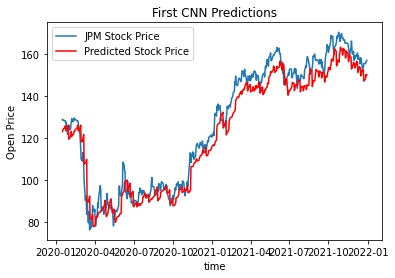

In [28]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_4.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [29]:
# AGGIUNGO UN LIVELLO CONVOLUTIVO IN PIù
set_seed(10)
model_5_CNN_5 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.Conv1D(40, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(30, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 3, 64)             256       
                                                                 
 conv1d_6 (Conv1D)           (None, 2, 40)             5160      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 40)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 30)                1230      
                                                                 
 dense_11 (Dense)            (None, 5)                 155       
                                                      

In [30]:
set_seed(10)
model_5_CNN_5.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_5_CNN_5.fit(X_train,y_train,epochs=20,batch_size=4)

Epoch 1/20
64/64 [==============================] - 1s 3ms/step - loss: 0.0828 - root_mean_squared_error: 0.2877
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0471 - root_mean_squared_error: 0.2171
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2162
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2162
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0467 - root_mean_squared_error: 0.2161
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0468 - root_mean_squared_error: 0.2164
Epoch 8/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0469 - root_mean_squared_error: 0.2165
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0467 - root_mean_squar

Mean Squared Error:	 1529.939118215967
Root Mean Squared Error:	 39.11443618686031


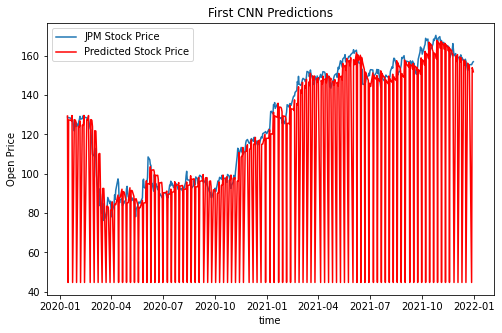

In [32]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_5.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [33]:
# USO COME FUNZIONE DI ATTIVAZIONE DEL LIVELLO DI OUTPUT LA FUNZIONE LINEARE
model_5_CNN_6 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "linear")
    ]
)
model_5_CNN_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
____________________________________________________

In [34]:
set_seed(10)
model_5_CNN_6.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_5_CNN_6.fit(X_train,y_train,epochs=20,batch_size=4)

Epoch 1/20
64/64 [==============================] - 1s 2ms/step - loss: 0.0592 - root_mean_squared_error: 0.2434
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 6.6166e-04 - root_mean_squared_error: 0.0257
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 6.8720e-04 - root_mean_squared_error: 0.0262
Epoch 5/20
64/64 [==============================] - 0s 1ms/step - loss: 6.3522e-04 - root_mean_squared_error: 0.0252
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 6.8064e-04 - root_mean_squared_error: 0.0261
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 7.0212e-04 - root_mean_squared_error: 0.0265
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 7.2729e-04 - root_mean_squared_error: 0.0270
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 

Mean Squared Error:	 29.26675111182205
Root Mean Squared Error:	 5.409875332373385


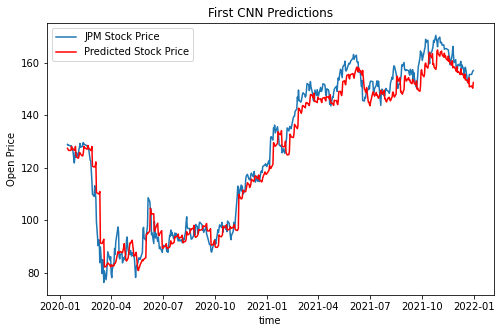

In [35]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_6.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show() 

In [36]:
# WALK-FORWARD VALIDATION CON FINESTRA TEMPORALE DI 10 GIORNI
# training set
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set_scaled.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i+temp, 0])
  y_train.append(training_set_scaled[i:i+temp, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(253, 10)
(253, 10, 1)
(253, 5)


In [37]:
# creazione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp-temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.fit_transform(inputs)
print(inputs.shape)

X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i+temp, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(1765,)
(505,)
(505, 1)
(100, 10)
(100, 10, 1)


In [48]:
model_10_CNN = keras.Sequential(
    [
     keras.Input(shape=(10,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(45, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_10_CNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 8, 64)             256       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 45)                11565     
                                                                 
 dense_17 (Dense)            (None, 5)                 230       
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
__________________________________________________

In [49]:
batch_size = 4
epochs = 20
set_seed(10)
model_10_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_10_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0633 - root_mean_squared_error: 0.2516
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0465 - root_mean_squar

In [50]:
predicted_stock_price = model_10_CNN(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print(predicted_stock_price.shape)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print(dataset_test['Open'].shape)
print(predicted_stock_price.shape)

(500, 1)
(495,)
(495, 1)


Mean Squared Error:	 423.9877404695836
Root Mean Squared Error:	 20.59096259210782


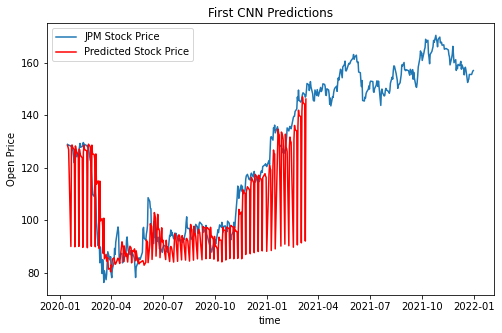

In [51]:
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price[0:290], label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show() 

RETE RICORRENTE

In [52]:
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True, activation="relu")(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_RNN = keras.Model(encoder_inputs, output)
model_RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_11 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 192)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 5, 192)           0         
 )                                                           

In [53]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_RNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
16/16 [==============================] - 2s 9ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 6/20
16/16 [==============================] - 0s 10ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 8/20
16/16 [==============================] - 0s 10ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 9/20
16/16 [==============================] - 0s 10ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 10/20
16/16 [==============================] - 0s 11ms/step - loss: 0.2308 - MSE: 0.2308
Epoch 11/20
16/16 [==============================] - 0s 10ms/ste

Mean Squared Error:	 3358.7713307978997
Root Mean Squared Error:	 57.9549077369458


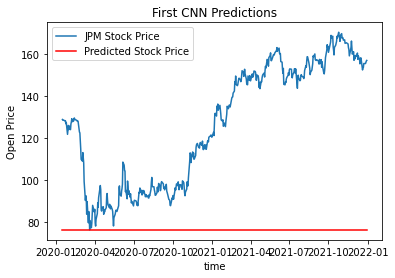

In [55]:
# MSE ed previsioni
predicted_stock_price = model_RNN.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [ ]:
# cambio della funzione di attivazione nel layer LSTM e del primo layer denso

In [56]:
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_RNN_2 = keras.Model(encoder_inputs, output)
model_RNN_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_13 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 192)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 192)           0         
 or)                                                       

In [57]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN_2.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_RNN_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
16/16 [==============================] - 2s 9ms/step - loss: 0.0623 - root_mean_squared_error: 0.2496
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 4.1472e-04 - root_mean_squared_error: 0.0204
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 3.8289e-04 - root_mean_squared_error: 0.0196
Epoch 7/20
16/16 [==============================] - 0s 8ms/step - loss: 3.3120e-04 - root_mean_squared_error: 0.0182
Epoch 8/20
16/16 [==============================] - 0s 9ms/step - loss: 4.3024e-04 - root_mean_squared_error: 0.0207
Epoch 9/20
16/16 [==============================] - 0s 9ms/step - loss: 3.7704e-

Mean Squared Error:	 33.62689272358721
Root Mean Squared Error:	 5.7988699522913265


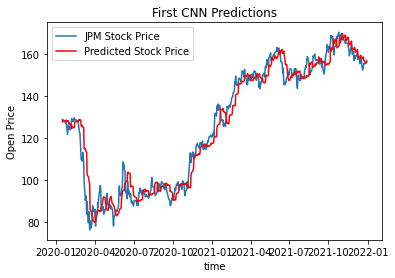

In [59]:
# MSE ed previsioni
predicted_stock_price = model_RNN_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [60]:
# provo a modificare il learning rate a 0.02
model_RNN_3 = keras.Model(encoder_inputs, output)
model_RNN_3.summary()

batch_size = 16
epochs = 20
set_seed(456984)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model_RNN_3.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model_RNN_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_13 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 192)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 192)           0         
 or)                                                       

Mean Squared Error:	 3358.7713307978997
Root Mean Squared Error:	 57.9549077369458


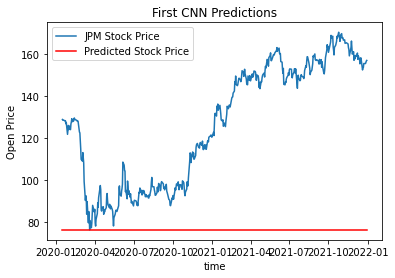

In [62]:
predicted_stock_price = model_RNN_3.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [63]:
# diminuisco il kernel_size a 2 nei livelli convolutivi
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 2, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 2, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_RNN_4 = keras.Model(encoder_inputs, output)
model_RNN_4.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 9, 64)             192       
                                                                 
 conv1d_15 (Conv1D)          (None, 8, 64)             8256      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 256)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 256)           0         
 or)                                                       

In [64]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN_4.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_RNN_4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
16/16 [==============================] - 2s 12ms/step - loss: 0.0566 - root_mean_squared_error: 0.2379
Epoch 2/20
16/16 [==============================] - 0s 11ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 9.1317e-04 - root_mean_squared_error: 0.0302
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 3.2740e-04 - root_mean_squared_error: 0.0181
Epoch 6/20
16/16 [==============================] - 0s 10ms/step - loss: 3.2412e-04 - root_mean_squared_error: 0.0180
Epoch 7/20
16/16 [==============================] - 0s 10ms/step - loss: 2.7136e-04 - root_mean_squared_error: 0.0165
Epoch 8/20
16/16 [==============================] - 0s 9ms/step - loss: 3.5048e-04 - root_mean_squared_error: 0.0187
Epoch 9/20
16/16 [==============================] - 0s 9ms/step - loss

Mean Squared Error:	 29.83302016672132
Root Mean Squared Error:	 5.461961201502746


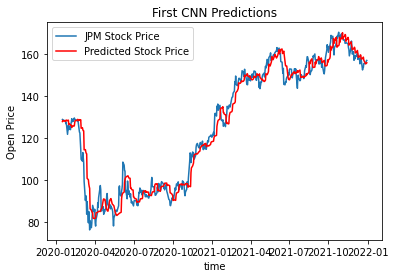

In [65]:
predicted_stock_price = model_RNN_4.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [66]:
# aggiungo un livello lstm in parallelo a quello già esistente; entrambi con funzione di attivazione tanh
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 2, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder1 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
decoder_lstm2 = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder2 =keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm2)
conc = keras.layers.concatenate([decoder1,decoder2])
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(conc)

model_RNN_5 = keras.Model(encoder_inputs, output)
model_RNN_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 8, 64)        256         ['input_13[0][0]']               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 7, 64)        8256        ['conv1d_16[0][0]']              
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 3, 64)       0           ['conv1d_17[0][0]']              
 )                                                                                          

In [67]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN_5.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_RNN_5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
16/16 [==============================] - 4s 13ms/step - loss: 0.1065 - root_mean_squared_error: 0.3264
Epoch 2/20
16/16 [==============================] - 0s 13ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648
Epoch 4/20
16/16 [==============================] - 0s 13ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430
Epoch 5/20
16/16 [==============================] - 0s 13ms/step - loss: 7.9820e-04 - root_mean_squared_error: 0.0283
Epoch 6/20
16/16 [==============================] - 0s 13ms/step - loss: 6.2591e-04 - root_mean_squared_error: 0.0250
Epoch 7/20
16/16 [==============================] - 0s 13ms/step - loss: 4.8493e-04 - root_mean_squared_error: 0.0220
Epoch 8/20
16/16 [==============================] - 0s 13ms/step - loss: 6.2038e-04 - root_mean_squared_error: 0.0249
Epoch 9/20
16/16 [==============================] - 0s 13ms/step - loss:

Mean Squared Error:	 37.10754793656393
Root Mean Squared Error:	 6.091596501457063


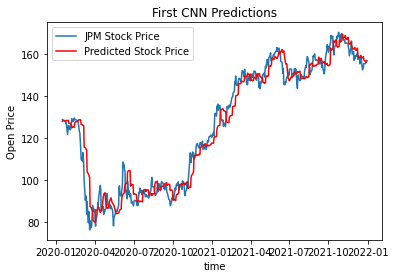

In [68]:
predicted_stock_price = model_RNN_5.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()